In [1]:
import os, random
import cv2
import numpy as np
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    FoVPerspectiveCameras, RasterizationSettings, MeshRenderer, MeshRasterizer, Materials,
    BlendParams, SoftPhongShader, HardPhongShader, PointLights, TexturesVertex, look_at_rotation
)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def load_backgrounds(bg_folder):
    bg_files = [os.path.join(bg_folder, f) for f in os.listdir(bg_folder)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    backgrounds = [cv2.imread(f) for f in bg_files]
    # Convert BGR to RGB
    backgrounds = [cv2.cvtColor(bg, cv2.COLOR_BGR2RGB) for bg in backgrounds]
    return backgrounds

def load_foreign_objects(obj_folder):
    obj_files = [os.path.join(obj_folder, f) for f in os.listdir(obj_folder)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    foreign_objs = [cv2.imread(f, cv2.IMREAD_UNCHANGED) for f in obj_files]
    # Assume these images have alpha channels or are prepared to be overlaid.
    return foreign_objs

def sample_clip_camera_pose():
    azimuth = random.uniform(-85, 85)
    elevation = random.uniform(-85, 85)  # adjust as needed
    distance = random.uniform(20, 60)
    # Convert spherical coordinates to Cartesian:
    x = distance * np.cos(np.radians(elevation)) * np.cos(np.radians(azimuth))
    y = distance * np.cos(np.radians(elevation)) * np.sin(np.radians(azimuth))
    z = distance * np.sin(np.radians(elevation))
    return torch.tensor([x, y, z], dtype=torch.float32)

def sample_light_position(device):
    base = np.array([2.0, 2.0, -2.0])
    offset = np.random.uniform(-1.0, 1.0, size=3)
    pos = base + offset
    return torch.tensor(pos, dtype=torch.float32, device=device)

def generate_occlusion_mask(image_size, occlusion_level=0.3):
    mask = np.ones((image_size, image_size), dtype=np.float32)
    occlusion_pixels = int(occlusion_level * image_size)
    # Instead of occluding mask[:occlusion_pixels, :], occlude the bottom rows:
    mask[-occlusion_pixels:, :] = 0
    return mask

def composite_images(background, foreground, mask):
    """
    background: RGB image (H, W, 3) as float32 [0,1]
    foreground: RGB image (H, W, 3) as float32 [0,1]
    mask: single-channel float32 image (H, W) [0,1] (alpha)
    """
    return foreground * mask[..., None] + background * (1 - mask[..., None])

In [4]:
# Load the mesh geometry
clip_mesh_path = "/home/exouser/pose_estim/clipestimator/data/mesh/clipMesh.obj"
verts, faces_idx, _ = load_obj(clip_mesh_path)
faces = faces_idx.verts_idx

# Create the silver color first
silver_color = 0.8 * torch.ones_like(verts)[None]  # shape = [1, V, 3]
silver_color[..., 2] += 0.05  # optionally tweak one channel for a slightly different tint
textures_silver = TexturesVertex(verts_features=silver_color.to(device))

# Build the mesh with the silver texture
clip_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures_silver
)

# Now set up your renderer as usual
cameras = FoVPerspectiveCameras(device=device)
blend_params = BlendParams(sigma=3e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
    faces_per_pixel=25,
    bin_size=0,
)
lights = PointLights(
    device=device, 
    location=sample_clip_camera_pose().to(device).unsqueeze(0),
    ambient_color=((0.9, 0.7, 0.7),),
    diffuse_color=((1.0, 1.0, 1.0),),
    specular_color=((1.0, 1.0, 1.0),)
)
materials = Materials(
    device=device,
    ambient_color=((0.4, 0.4, 0.4),),
    diffuse_color=((0.5, 0.5, 0.5),),
    specular_color=((1.0, 1.0, 1.0),),
    shininess=200.0
)
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights, materials=materials)
)


/home/exouser/anaconda3/envs/blvenv/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: /home/exouser/pose_estim/clipestimator/data/mesh/Item.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [5]:
backgrounds = load_backgrounds("/home/exouser/pose_estim/clipestimator/data/backgrounds")
foreign_objects = load_foreign_objects("/home/exouser/pose_estim/clipestimator/data/objects")

In [9]:
to_float = lambda img: img.astype(np.float32) / 255.0

def generate_synthetic_sample():
    # 1. Sample a random background and resize to renderer resolution.
    bg = random.choice(backgrounds)
    bg = cv2.resize(bg, (256, 256))
    bg = to_float(bg)
    
    # 2. Sample camera pose for clip (ensuring back hemisphere view)
    cam_pos = sample_clip_camera_pose().to(device)
    
    # 3. Update light position randomly (make sure to update as a tensor)
    lights.location = sample_light_position(device).unsqueeze(0)
    
    # 4. Render the clip using PyTorch3D.
    R = look_at_rotation(cam_pos[None, :], device=device)
    T = -torch.bmm(R.transpose(1, 2), cam_pos[None, :, None])[:, :, 0]
    rendered = renderer(meshes_world=clip_mesh, R=R, T=T)
    rendered = rendered[0].detach().cpu().numpy()
    clip_rgb = rendered[..., :3]
    clip_alpha = rendered[..., 3]
    
    # 5. Apply occlusion.
    occlusion_level = random.uniform(0.0, 0.6)
    occ_mask = generate_occlusion_mask(256, occlusion_level=occlusion_level)
    clip_alpha_occluded = clip_alpha * occ_mask
    
    # 6. Composite the rendered clip over the background.
    composite_img = composite_images(bg, clip_rgb, clip_alpha_occluded)
    
    # 7. Optionally add a foreign object.
    if random.random() < 0.5 and foreign_objects:
        obj_img = random.choice(foreign_objects)
        obj_img = cv2.resize(obj_img, (256, 256))
        if obj_img.shape[2] == 3:
            alpha_channel = np.ones((256,256,1), dtype=obj_img.dtype) * 255
            obj_img = np.concatenate([obj_img, alpha_channel], axis=2)
        obj_img = to_float(obj_img)
        obj_alpha = obj_img[..., 3]
        obj_rgb = obj_img[..., :3]
        composite_img = composite_images(composite_img, obj_rgb, obj_alpha)
    
    # 8. Post-process: add noise.
    noise = np.random.normal(0, 0.02, composite_img.shape)
    composite_img = np.clip(composite_img + noise, 0, 1)
    
    gt_rotation = R[0].detach().cpu().numpy()
    gt_translation = T[0].detach().cpu().numpy()
    return (composite_img, gt_rotation, gt_translation)


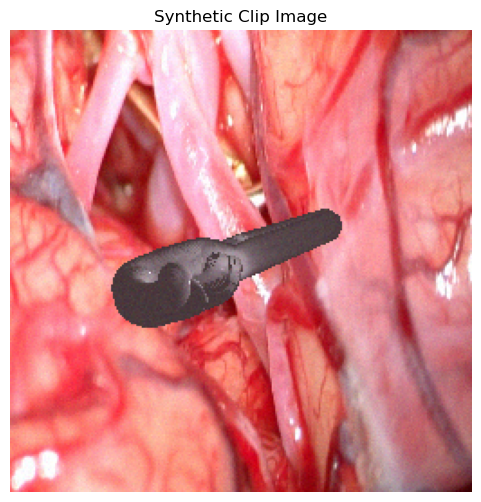

Ground Truth Rotation:
 [[ 0.8694541  -0.32273033 -0.37402502]
 [-0.          0.7571146  -0.6532821 ]
 [ 0.49401376  0.56799877  0.6582764 ]]
Ground Truth Translation:
 [-0.0000000e+00 -1.9073486e-06  4.3412704e+01]


In [10]:
sample_img, gt_R, gt_T = generate_synthetic_sample()

plt.figure(figsize=(6,6))
plt.imshow(sample_img)
plt.title("Synthetic Clip Image")
plt.axis("off")
plt.show()

print("Ground Truth Rotation:\n", gt_R)
print("Ground Truth Translation:\n", gt_T)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1307828].


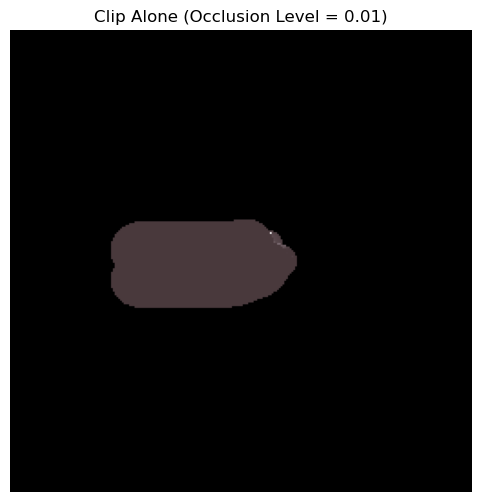

In [8]:
def test_render_clip_alone():
   
    # Sample a random camera position in the back hemisphere
    cam_pos = sample_clip_camera_pose().to(device)
    
    # Sample a random occlusion level (0 to 0.6)
    occlusion_level = 0.01 #random.uniform(0.0, 0.6)
    
    # Update the light position randomly
    #lights.location = sample_light_position(device).unsqueeze(0)
    
    # Render the clip
    R = look_at_rotation(cam_pos[None, :], device=device)
    T = -torch.bmm(R.transpose(1, 2), cam_pos[None, :, None])[:, :, 0]
    rendered = renderer(meshes_world=clip_mesh, R=R, T=T)[0].detach().cpu().numpy()
    
    # Extract RGB and alpha
    clip_rgb = rendered[..., :3]
    clip_alpha = rendered[..., 3]
    
    # Apply occlusion
    occ_mask = generate_occlusion_mask(256, occlusion_level=occlusion_level)
    clip_alpha_occluded = clip_alpha * occ_mask
    
    # Composite onto a black background:
    # out_img = clip_rgb * alpha + black * (1 - alpha) = clip_rgb * alpha
    out_img = clip_rgb * clip_alpha[..., None] # change to clip_alpha_occluded to incorporate occlusions
    
    # Display the result
    plt.figure(figsize=(6, 6))
    plt.imshow(out_img)
    plt.title(f"Clip Alone (Occlusion Level = {occlusion_level:.2f})")
    plt.axis("off")
    plt.show()

# test:
test_render_clip_alone()
